# High-level overview & motivation

## Motivation

I wanted to investigate how code obfuscation affects modern, high-quality code generation models that are comparable to those used in realistic scenarios today.  
Models in this category are the same type that power advanced code completion tools and assistants (for example via cloud APIs, and in some cases also through optimized deployments for systems like GitHub Copilot).

The goal was to see whether masking information in programming tasks significantly harms the ability of such models to recover correct functionality.


## Experiment setup

For this experiment I use the **HumanEval dataset** from HuggingFace, which contains Python programming tasks with reference solutions and test cases.

For each task, I generate three prompt variants:

### 1. Original prompt
- No changes are applied.

### 2. Low obfuscation
The following elements are masked:
- The original function name is replaced by `func`
- All variable and parameter names are renamed to generic placeholders like `var_1`, `var_2`, ...
- Python keywords, builtins, imports and common typing types (e.g. `List`, `Optional`) are preserved
- The descriptive docstring text remains readable (except for doctest lines where the function name is replaced)

### 3. High obfuscation
In addition to the low obfuscation:
- The natural language description inside the docstring is completely removed  
- Only the input/output examples (doctest-style) are kept  
- This means the model no longer receives any explicit textual explanation of the task, only observed I/O behaviour  
- Semantic clues and human-readable structure are therefore heavily reduced  

**Example below (after the obfuscation functions).**


## Model usage

For code generation, I call the OpenAI API with the model:
- **gpt-4.1-mini**

In [9]:
# Please set OpenAI API Key: 

OPENAI_API_KEY = "PLEASE REPLACE WITH API KEY"

## Evaluation

To ensure a robust and fair evaluation, the raw model outputs (which only contain the generated function body) are programmatically merged back into the corresponding prompt version (original, low or high obfuscation).

This reconstruction preserves the structure and signature of the respective prompt variant and inserts the generated logic at the correct indentation level, resulting in a valid, executable Python function.

The resulting function is then executed together with the official HumanEval test code (from the `test` column) in a shared namespace.  
Using this approach, each generated solution is evaluated in its true functional context, ensuring that the pass/fail outcome reflects real runtime correctness rather than superficial text similarity.

This makes the evaluation robust against formatting artifacts and isolates performance strictly to the quality of the generated logic.



## Required installations

To run the notebook end-to-end, the following Python packages are required:

```bash
pip install datasets pandas python-Levenshtein openai matplotlib

In [2]:
# Third-party libraries
from datasets import load_dataset
import pandas as pd

# Standard library
import re
import io
import tokenize
import keyword
import builtins

def _replace_funcname_in_doctests(literal: str, old_name: str, new_name: str) -> str:
    """Replace function name only in doctest lines (those starting with '>>>')."""
    lines = literal.split("\n")
    new_lines = []
    for line in lines:
        stripped = line.lstrip()
        if stripped.startswith(">>>") and old_name in line:
            new_lines.append(line.replace(old_name, new_name))
        else:
            new_lines.append(line)
    return "\n".join(new_lines)


def low_obfuscation(prompt: str) -> str:
    """
    Low obfuscation for HumanEval-style prompts (exactly one function):

    - Rename the single function name to 'func' in code and doctest lines.
    - Rename all other identifiers (parameters, variables, etc.) to var_1, var_2, ...
    - Do NOT touch:
        * imports and imported type names (lines starting with 'import' / 'from')
        * Python keywords and builtins
        * common typing type names (List, Tuple, Optional, Dict, Set, ...)
        * docstring description text und example values
    """
    tokens = list(tokenize.generate_tokens(io.StringIO(prompt).readline))

    builtin_names = set(dir(builtins))
    # Typing-Typen, die NICHT obfuskiert werden sollen
    typing_type_names = {
        "List", "Tuple", "Optional", "Dict", "Set", "FrozenSet",
        "Sequence", "Iterable", "Mapping", "Callable", "Any",
        "Union", "DefaultDict", "Deque", "Counter", "Literal",
        "Type", "NamedTuple",
    }

    # -------- First pass: find function name --------
    old_func_name = None
    after_def = False

    for tok in tokens:
        ttype, tstr, *_ = tok
        if ttype == tokenize.NAME:
            if tstr == "def":
                after_def = True
                continue
            if after_def and old_func_name is None:
                old_func_name = tstr
                after_def = False
                break
        elif ttype not in (tokenize.NEWLINE, tokenize.NL, tokenize.INDENT, tokenize.DEDENT):
            after_def = False

    if old_func_name is None:
        # Nothing to obfuscate
        return prompt

    new_func_name = "func"

    # -------- Second pass: rewrite tokens --------
    var_mapping = {}
    var_counter = 1

    def get_var_name(name: str) -> str:
        nonlocal var_counter
        if name not in var_mapping:
            var_mapping[name] = f"var_{var_counter}"
            var_counter += 1
        return var_mapping[name]

    new_tokens = []
    after_def = False
    in_import_line = False

    for tok in tokens:
        ttype, tstr, start, end, line = tok

        # Detect import lines: 'import ...' or 'from ... import ...'
        if ttype == tokenize.NAME and tstr in ("import", "from"):
            in_import_line = True
        if ttype in (tokenize.NEWLINE, tokenize.NL):
            in_import_line = False

        # Handle identifiers
        if ttype == tokenize.NAME:
            # Keep 'def', but remember next NAME is function name
            if tstr == "def":
                new_tokens.append(tok)
                after_def = True
                continue

            # Function name in definition
            if after_def:
                new_tokens.append(
                    tokenize.TokenInfo(ttype, new_func_name, start, end, line)
                )
                after_def = False
                continue

            # Function name elsewhere in code
            if tstr == old_func_name:
                new_tokens.append(
                    tokenize.TokenInfo(ttype, new_func_name, start, end, line)
                )
                continue

            # Imports: do not rename anything on these lines
            if in_import_line:
                new_tokens.append(tok)
                continue

            # Keywords and builtins: keep
            if tstr in keyword.kwlist or tstr in builtin_names:
                new_tokens.append(tok)
                continue

            # Typing types: keep (List, Tuple, Optional, ...)
            if tstr in typing_type_names:
                new_tokens.append(tok)
                continue

            # All other identifiers → var_*
            new_name = get_var_name(tstr)
            new_tokens.append(
                tokenize.TokenInfo(ttype, new_name, start, end, line)
            )

        # Handle strings (docstring and others)
        elif ttype == tokenize.STRING:
            if old_func_name in tstr:
                new_str = _replace_funcname_in_doctests(tstr, old_func_name, new_func_name)
                new_tokens.append(
                    tokenize.TokenInfo(ttype, new_str, start, end, line)
                )
            else:
                new_tokens.append(tok)
            after_def = False

        else:
            new_tokens.append(tok)
            if ttype not in (tokenize.NL, tokenize.NEWLINE, tokenize.INDENT, tokenize.DEDENT):
                after_def = False

    return tokenize.untokenize(new_tokens)

In [3]:


def _high_obfuscate_docstring(doc_literal: str) -> str:
    """Keep only doctests (>>> ...) and their outputs inside the docstring."""
    quote = doc_literal[:3]
    inner = doc_literal[3:-3]

    lines = inner.split("\n")
    kept = []
    i = 0

    while i < len(lines):
        line = lines[i]
        stripped = line.lstrip()

        if stripped.startswith(">>>"):
            # keep doctest input line
            kept.append(line)

            # keep one following output line if it is non-empty and not another doctest
            if i + 1 < len(lines):
                nxt = lines[i + 1]
                nxt_stripped = nxt.lstrip()
                if nxt_stripped and not nxt_stripped.startswith(">>>"):
                    kept.append(nxt)
                    i += 1
        # descriptive lines are skipped
        i += 1

    if not kept:
        kept = ['>>> func()']

    new_inner = "\n".join(kept)
    return quote + "\n" + new_inner + "\n" + quote


def _apply_high_docstring(text: str) -> str:
    """Find the first triple-quoted string and apply high-level docstring obfuscation."""
    # find first """ or '''
    idx_dq = text.find('"""')
    idx_sq = text.find("'''")

    candidates = [(idx_dq, '"""'), (idx_sq, "'''")]
    candidates = [(i, q) for i, q in candidates if i != -1]

    if not candidates:
        return text  # no docstring found

    start, quote = min(candidates, key=lambda x: x[0])
    end = text.find(quote, start + 3)
    if end == -1:
        return text  # malformed, just bail out

    doc_literal = text[start:end + 3]
    new_doc = _high_obfuscate_docstring(doc_literal)

    return text[:start] + new_doc + text[end + 3:]
    

def high_obfuscation(prompt: str) -> str:
    """
    High obfuscation:

    - First apply low_obfuscation (func/var names anonymized, doctests angepasst).
    - Then:
        * Docstring: remove descriptive text, keep only doctest lines and outputs.
        * Imports: replace all import lines with a generic comment.
    """
    low = low_obfuscation(prompt)
    with_high_doc = _apply_high_docstring(low)
    return with_high_doc



In [4]:
from datasets import load_dataset

# Show one concrete example (index 0) for all three variants
ds = load_dataset("openai/openai_humaneval", split="test")
ex = ds[0]
prompt = ex["prompt"]

print("--------- EXAMPLE (original vs. obfuscation levels) ---------\n")

# --- ORIGINAL ---------------------------------------------------
print("ORIGINAL (no obfuscation):\n")
print(prompt)

# --- LOW OBFUSCATION --------------------------------------------
print("\nLOW OBFUSCATION:")
print("  - function name is renamed to 'func'")
print("  - parameter and local variable names are renamed to var_1, var_2, ...")
print("  - imports, Python keywords, builtins and typing hints stay unchanged")
print("  - natural-language docstring text stays readable\n")
print(low_obfuscation(prompt))

# --- HIGH OBFUSCATION -------------------------------------------
print("\nHIGH OBFUSCATION:")
print("  - same renaming as LOW (func / var_1, var_2, ...)")
print("  - natural-language description inside the docstring is removed")
print("  - only I/O examples (doctest lines) are kept as guidance for the model\n")
print(high_obfuscation(prompt))


--------- EXAMPLE (original vs. obfuscation levels) ---------

ORIGINAL (no obfuscation):

from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """


LOW OBFUSCATION:
  - function name is renamed to 'func'
  - parameter and local variable names are renamed to var_1, var_2, ...
  - imports, Python keywords, builtins and typing hints stay unchanged
  - natural-language docstring text stays readable

from typing import List


def func(var_1: List[float], var_2: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> func([1.0, 2.0, 3.0], 0.5)
    False
    >>> func([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """


HIGH O

In [5]:
import os
import pandas as pd
from Levenshtein import distance as levenshtein_distance
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
client = OpenAI()


# System prompt that defines how the model should behave when generating code
SYSTEM_PROMPT = """
You are a Python code generation model.

STRICT RULES:
- Output ONLY valid Python code.
- No explanations. No comments. No markdown. No backticks.
- You MUST output ONLY the missing body of the given function, nothing else.
- DO NOT repeat the prompt or the function signature.
- DO NOT add new functions, classes, or imports.
- Your output must satisfy ALL input/output examples in the prompt.

INDENTATION RULES:
- Your first output line MUST start at indentation level 0 (no leading spaces).
  I will indent the entire function body myself after generation.
- Internal blocks (if, for, while, try, with, etc.) MUST use 4 spaces per indentation level.
- Never mix indentation styles. Use only spaces, no tabs.

BEHAVIOR RULES:
- If the docstring or comments contain only input → output examples (and no natural-language explanation),
  DO NOT try to produce the trivially minimal function that fits exactly those examples.
  Instead, infer a more general and reasonably complex function that could produce those outputs,
  as if the original natural-language description had been removed.

"""


def generate_completion(prompt: str,
                        model="gpt-4.1-mini",
                        max_tokens=256) -> str:
    """
    Call the chat completion API and return only the model text.
    The prompt already contains the function and docstring.
    """
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": prompt},
        ],
        max_tokens=max_tokens,
        temperature=0,
    )

    return response.choices[0].message.content.strip()


def privacy_score(original: str, obfuscated: str) -> float:
    """
    Compute a privacy score based on normalized Levenshtein distance
    between the original prompt and its obfuscated version.
    """
    if original == obfuscated:
        return 0.0
    dist = levenshtein_distance(original, obfuscated)
    denom = max(len(original), len(obfuscated)) or 1
    return dist / denom


def run_pipeline(low_obfuscation, high_obfuscation, model_name="gpt-4o-mini"):
    """
    Run the full experiment on the first 20 HumanEval test tasks:

    - create original, low-obfuscated and high-obfuscated prompts
    - generate completions for each variant
    - compute privacy scores
    - collect everything in a DataFrame
    """
    ds = load_dataset("openai/openai_humaneval", split="test[:20]")

    rows = []

    for i, ex in enumerate(ds):
        original_prompt = ex["prompt"]
        canonical = ex["canonical_solution"]

        # Three prompt variants for the same task
        variants = {
            "original": original_prompt,
            "low": low_obfuscation(original_prompt),
            "high": high_obfuscation(original_prompt),
        }

        print(f"\n===== EXAMPLE {i} =====")

        for variant_name, prompt_variant in variants.items():
            print(f"  -> Variant: {variant_name}")

            # Generate completion for this prompt variant
            completion = generate_completion(prompt_variant, model=model_name)

            # Original has privacy 0 by definition
            priv = 0.0 if variant_name == "original" else privacy_score(
                original_prompt, prompt_variant
            )

            rows.append({
                "example_id": i,
                "variant": variant_name,
                "prompt": prompt_variant,
                "completion": completion,
                "canonical_solution": canonical,
                "privacy": priv,
            })

    df = pd.DataFrame(rows)
    print("\nPipeline finished.")
    return df


# We call gpt-4.1-mini
df = run_pipeline(low_obfuscation, high_obfuscation, model_name="gpt-4.1-mini")



===== EXAMPLE 0 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 1 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 2 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 3 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 4 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 5 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 6 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 7 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 8 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 9 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 10 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

===== EXAMPLE 11 =====
  -> Variant: original
  -> Variant: low
  -> Variant: high

=

In [6]:

def assemble_function(prompt: str, completion: str) -> str:
    """
    The HumanEval prompt already contains:

    def func(...):
        \"\"\"doc...\"\"\"
        (model output should start here)

    This function appends the generated completion with correct indentation
    so it becomes a valid Python function.
    """
    # Indent model output by 4 spaces to match function body
    body = "\n".join("    " + l for l in completion.splitlines())
    return prompt.rstrip() + "\n" + body + "\n"


def run_humaneval_tests(df: pd.DataFrame, ds, log: bool = True) -> pd.DataFrame:
    """
    Execute the HumanEval tests on all generated functions.

    Expected columns in df:
      - example_id
      - prompt
      - completion
    """
    passed_list = []
    errors = []

    for _, row in df.iterrows():
        ex_id = int(row["example_id"])
        ex = ds[ex_id]

        prompt = row["prompt"]
        completion = row["completion"]

        # Build full function source including the generated body
        func_code = assemble_function(prompt, completion)
        test_code = ex["test"]
        combined = func_code + "\n\n" + test_code

        entry = ex["entry_point"]
        ns = {}

        if log:
            print("\n===================================================")
            print(f"EXAMPLE {ex_id} | variant={row.get('variant', 'n/a')}")
            print("--------------- FUNCTION + COMPLETION -------------")
            print(func_code)
            print("------------------------ TEST ---------------------")
            print(test_code)

        try:
            # Execute function and tests in the same namespace
            exec(combined, ns)

            check = ns["check"]
            candidate = ns.get(entry, None)

            # Fallback if the entry point was renamed (e.g. to 'func')
            if candidate is None:
                candidate = ns.get("func", None)

            if candidate is None:
                raise RuntimeError(
                    f"Candidate function '{entry}' (or 'func') not found."
                )

            # Run all assertions; AssertionError means fail
            check(candidate)

            passed_list.append(True)
            errors.append("")
            if log:
                print("----True----")

        except Exception as e:
            passed_list.append(False)
            errors.append(repr(e))
            if log:
                print("----False----")
                print("Error:", repr(e))

    df2 = df.copy()
    df2["passed"] = passed_list
    df2["error"] = errors
    return df2


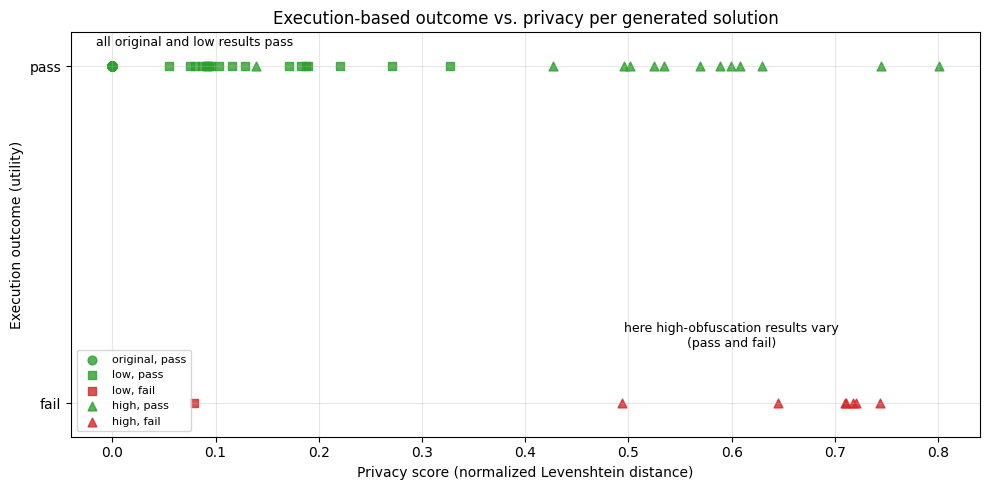

In [7]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# Run HumanEval tests first
ds = load_dataset("openai/openai_humaneval", split="test[:20]")
eval_df = run_humaneval_tests(df, ds, log=False)

plt.figure(figsize=(10, 5))

# Marker per variant, color per pass/fail
marker_map = {"original": "o", "low": "s", "high": "^"}
color_map_pass = {True: "tab:green", False: "tab:red"}

for variant in ["original", "low", "high"]:
    subset = eval_df[eval_df["variant"] == variant]
    if subset.empty:
        continue

    for passed_value in [True, False]:
        sub2 = subset[subset["passed"] == passed_value]
        if sub2.empty:
            continue

        plt.scatter(
            sub2["privacy"],
            sub2["passed"].astype(int),  # 1 = pass, 0 = fail
            marker=marker_map.get(variant, "o"),
            c=color_map_pass[passed_value],
            label=f"{variant}, {'pass' if passed_value else 'fail'}",
            alpha=0.8,
            s=40,
        )

# Axis formatting
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ["fail", "pass"])
plt.xlabel("Privacy score (normalized Levenshtein distance)")
plt.ylabel("Execution outcome (utility)")
plt.title("Execution-based outcome vs. privacy per generated solution")
plt.grid(alpha=0.3)

# Short textual hints directly in the plot
# All green circles/squares on the pass line (original + low)
plt.text(
    0.08, 1.05,
    "all original and low results pass",
    ha="center",
    va="bottom",
    fontsize=9,
)

# Region where high-obfuscation results are mixed
plt.text(
    0.6, 0.2,
    "here high-obfuscation results vary\n(pass and fail)",
    ha="center",
    va="center",
    fontsize=9,
)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), fontsize=8)

plt.tight_layout()
plt.show()


## Analysis of the observed trade-off

The final plot shows **one point per generated solution**:
- x-axis: privacy score (normalized Levenshtein distance between original and obfuscated prompt)
- y-axis: execution outcome (pass/fail on the HumanEval tests)
- shape: obfuscation level (circle = original, square = low, triangle = high)
- color: green for passed tests, red for failed tests


The results show a clear asymmetry between light and strong obfuscation.

With **low obfuscation**, my execution-based evaluation revealed **no functional performance loss**.  
The model behaved identically to the original setting, which indicates that simple anonymization of identifiers is effectively *free privacy* in this context.

Under **high obfuscation**, where the natural-language description was removed and only I/O examples remained, performance dropped as expected.  
This is reasonable since sparse I/O examples often do not uniquely specify the task.

However, despite this reduced context, the model still achieved a surprisingly strong level of correctness:
- Approximately **60% of solutions passed all HumanEval tests**.
- This indicates that the model was frequently able to infer the intended functionality from weak structural signals alone.

The practical implication is that the most useful operating point lies **between low and high obfuscation**, where privacy is increased without significantly harming functional correctness.

A concrete example of this behaviour is shown below, where the model solved a task correctly even under high obfuscation and minimal contextual information.


In [8]:
# Example: High obfuscation with correct outcome
# EXAMPLE 7 | variant=high

# Generated function from the model (after strong obfuscation):
from typing import List

def func(var_1: List[str], var_2: str) -> List[str]:
    """
    >>> func([], 'a')
    []
    >>> func(['abc', 'bacd', 'cde', 'array'], 'a')
    ['abc', 'bacd', 'array']
    """
    return [s for s in var_1 if var_2 in s]


# Official tests from the HumanEval / HuggingFace dataset:
def check(candidate):
    assert candidate([], 'john') == []
    assert candidate(['xxx', 'asd', 'xxy', 'john doe', 'xxxAAA', 'xxx'], 'xxx') == ['xxx', 'xxxAAA', 'xxx']
    assert candidate(['xxx', 'asd', 'aaaxxy', 'john doe', 'xxxAAA', 'xxx'], 'xx') == ['xxx', 'aaaxxy', 'xxxAAA', 'xxx']
    assert candidate(['grunt', 'trumpet', 'prune', 'gruesome'], 'run') == ['grunt', 'prune']

# Small wrapper to print True / False instead of None
try:
    check(func)          
    print("True")        
except AssertionError as e:
    print("False")       
    print("Error:", e)


True
